In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import randint
from scipy.optimize import curve_fit
from scipy.stats import poisson
import random

In [2]:
def get_all_files(filename,ending='.root'):
    dir_path = './'

    index=[i+1 for i in range(len(filename)) if  filename[i]=='/']
    if len(index)>0:
        dir_path=filename[:index[-1]]
        filename=filename[index[-1]:]

    res = []
    filelist=os.listdir(dir_path)
    filelist.sort()
    for file in filelist:
        if file.startswith(filename) and file.endswith(ending):
            res.append(f'{dir_path}{file}')
    return res

In [3]:
def df_to_list(xtmp):
    x = []
    for i in range(len(xtmp)):
        str=xtmp[i][1:-1]
        try:
            str.index(',')
            sep=','
        except ValueError:
            sep=' '
        
        tmp=np.fromstring(str, dtype=float, sep=sep)
        x.append(tmp)
    return x


In [4]:
def draw_subplots(xlabel,ylim,yscale='linear',draw_lines='none',ylabel='', radius=[0,100,125,150,175,200,225,250,265]):
    # capture radius for all events
    nrows=int(np.ceil(len(radius)/3))
    ncol=3
    if len(radius)<4:
        ncol=len(radius)
    fig, axss = plt.subplots(nrows, ncol, figsize=(ncol*4,nrows*4),sharex=True)
    axs=axss.reshape(nrows,ncol)
    for i in range(len(radius)):
        idx1=int(i/3)
        idx2=i%3
        if draw_lines=='lines':
            axs[idx1][idx2].axvline(x=0.95,color='lightgray',linestyle='dotted')
            axs[idx1][idx2].axvline(x=2.75,color='lightgray',linestyle='dotted')
            axs[idx1][idx2].axvline(x=3.25,color='lightgray',linestyle='dotted')
            if radius[i] > 0:
                axs[idx1][idx2].axvline(x=radius[i]/100.,color='lightgray',linestyle='dotted')
        if draw_lines=='radius':
            theta = np.arange(0, np.pi * 2, 0.01)
            axs[idx1][idx2].plot(0.95 * np.cos(theta), 0.95 * np.sin(theta),color='black')
            axs[idx1][idx2].plot(2.75 * np.cos(theta), 2.75 * np.sin(theta),color='black')
            axs[idx1][idx2].plot(3.25 * np.cos(theta), 3.25* np.sin(theta),color='black')
            axs[idx1][idx2].plot(5.5 * np.cos(theta), 5.5* np.sin(theta),color='black')
            if radius[i] > 0:
                axs[idx1][idx2].plot(radius[i]/100. * np.cos(theta), radius[i]/100. * np.sin(theta),color='black')
                axs[idx1][idx2].plot((radius[i]/100.+0.1) * np.cos(theta), (radius[i]/100.+0.1) * np.sin(theta),color='black')
        if draw_lines=='rectangle':
            axs[idx1][idx2].set_xlim(-7,7)
            axs[idx1][idx2].set_ylim(-8,5)
            rcryo_inner = plt.Rectangle((-2.75,-3.75), 5.5, 5.5,ec="black",facecolor='none')
            rcryo = plt.Rectangle((-3.25,-4.25), 6.5, 6.5,ec="black",facecolor='none')
            rwater_tank = plt.Rectangle((-5.5,-7.5), 11, 13,ec="black",facecolor='none')
            axs[idx1][idx2].add_patch(rwater_tank)
            axs[idx1][idx2].add_patch(rcryo)
            axs[idx1][idx2].add_patch(rcryo_inner)
            axs[idx1][idx2].set_ylim(-8,6)
            axs[idx1][idx2].set_xlim(-6,6)
        axs[idx1][idx2].set_title(f'r={radius[i]}cm')
        axs[idx1][idx2].set_ylim(ylim[0],ylim[1])
        axs[idx1][idx2].set_yscale(yscale)
        axs[idx1][idx2].set_ylabel(ylabel)
        if idx1==nrows-1:
            axs[idx1][idx2].set_xlabel(xlabel)
        if idx2==0:
            axs[idx1][idx2].set_ylabel(ylabel)
    return [fig,axs]

In [5]:
def read_csv(filenames,ending='.csv'):
    files=get_all_files(filenames,ending)
    nCA = []
    nCZ = []
    cross_cryo = []
    #print(f"Reading in data... ({files})")
    #df_in = []
    for file in tqdm(files):
        df_in = pd.read_csv(file,skiprows=1)
    #    print(df_in)
        df_in.to_numpy()

        nCA.extend(df_in['nC_A'].to_numpy())
        nCZ.extend(df_in['nC_Z'].to_numpy())
        cross_cryo.extend(df_in['cross_cryo'].to_numpy())
    return [nCA,nCZ,cross_cryo]

In [6]:
def read_design_parameters(filenames,ending='.csv'):
    files=get_all_files(filenames,ending)
    params = []
    for idx,file in enumerate(files):
        with open(file) as f:
            first_line = f.readline()
            first_line=first_line[first_line.find('[')+1:first_line.find(']')]
            x = [k for k in first_line.split(",")]
            if idx==0:
                params=x
            elif idx > 0 and params!=x:
                print(f"Error {files[idx-1]} and {files[idx]} don't have the same parameters")
    return params

In [7]:

nSamples=0
version = 'v1.6'
versions = ['v1.6']
if not os.path.exists(f'out/{version}'):
   os.makedirs(f'out/{version}')
nCA = []
nCZ = []
iidx = []
nprimaries = []
cross_cryo = []
nLF=0
sim_mode = []
radius = []
design = []
thickness = []
theta = []
phi = []
npanels = []
Length = []
zpos = []
volume = []
height = []
nHF=0
sample = []
for v in versions:
   paths_lf=[]
   dir_path_lf=f'../simulation/out/LF/{v}/new_samples'
   samples_lf=[]
   for path in os.scandir(dir_path_lf):
        if path.is_file():
            #if 'neutron-sim-D4-LF' in path.name:
            name=path.name.split('_000')[0]
            paths_lf.append(f'{dir_path_lf}/{name}')
            samples_lf.append(int(name.split('-n')[1]))
   paths_lf=(list(set(paths_lf)))
   paths_lf.sort()
   samples_lf=(list(set(samples_lf)))
   samples_lf.sort()

   samples_hf=[]
   paths_hf=[]
   dir_path_hf=f'../simulation/out/HF/{v}'
   for path in os.scandir(dir_path_hf):
      if not path.is_file():
         if 'Neutron-Simulation-HF' in path.name:
            paths_hf.append(f'{dir_path_hf}/{path.name}')
            samples_hf.append(int(path.name.split('-N')[1]))
   paths_hf.sort()
   samples_hf.sort()

   if samples_hf != samples_lf:
      tmp=list(set(samples_lf).intersection(set(samples_hf)))
      samples_hf=[list(samples_hf).index(i) for i in tmp]
      samples_lf=[list(samples_lf).index(i) for i in tmp]
      paths_hf=[list(paths_hf).index(i) for i in tmp]
      paths_lf=[list(paths_lf).index(i) for i in tmp]
      
   
   for j,filename in enumerate(paths_lf):
      #filename=f'../simulation/out/LF/{version}/new_samples/neutron-sim-D4-LF-n{m}_'
      tmp=np.array(read_design_parameters(filename))
      sim_mode.append(tmp[0])
      design.append(float(tmp[1]))
      radius.append(float(tmp[2]))
      height.append(float(tmp[8]))
      thickness.append(float(tmp[3]))
      volume.append(float(tmp[10]))
      Length.append(float(tmp[7]))
      theta.append(float(tmp[6]))
      zpos.append(float(tmp[9]))
      npanels.append(float(tmp[4]))
      phi.append(float(tmp[5])/np.pi*180.)
      [nCA000,nCZ000,cross_cryo000] = read_csv(filename)
      nprimaries.append(25000*len(get_all_files(filename,ending='.csv')))
      iidx.append(len(nCA))
      nCA.extend(nCA000)
      nCZ.extend(nCZ000)
      cross_cryo.extend(cross_cryo000)
      sample.append(samples_lf[j])
      nLF+=1
      
   
   for j,dir in enumerate(paths_hf):
        filename=f'{dir}/neutron-sim-D4-HF-{v}-n{samples_hf[j]}_'
        tmp=np.array(read_design_parameters(filename))
        sim_mode.append(tmp[0])
        design.append(float(tmp[1]))
        radius.append(float(tmp[2]))
        height.append(float(tmp[8]))
        thickness.append(float(tmp[3]))
        volume.append(float(tmp[10]))
        Length.append(float(tmp[7]))
        theta.append(float(tmp[6]))
        zpos.append(float(tmp[9]))
        npanels.append(float(tmp[4]))
        phi.append(float(tmp[5])/np.pi*180.)
        [nCA000,nCZ000,cross_cryo000] = read_csv(filename)
        nprimaries.append(50000*len(get_all_files(filename,ending='.csv')))
        iidx.append(len(nCA))
        nCA.extend(nCA000)
        nCZ.extend(nCZ000)
        cross_cryo.extend(cross_cryo000)
        sample.append(samples_hf[j])
        nHF+=1
iidx.append(len(nCA))

100%|██████████| 197/197 [00:02<00:00, 66.87it/s]


In [8]:
scaling=1.365
Ge77factor=2599.8512051851676*scaling
Ge77factor_err=52.446566098836236*scaling
Ge77LFscaling=1494984/10100000
Ge77LFscaling_err=np.sqrt(1494984)/10100000
Ge77HFscaling=1

def fNPrimariesLF(scaling, n_neutrons):
    return n_neutrons/scaling
def fGe77Rate(nCZ,Ge77factor,nprimaries):
    return nCZ*(Ge77factor/nprimaries)

In [9]:
def monte_carlo_simulations(rate_mean, rate_std, n_iter=10000):
    outputs = []
    for i in range(n_iter):
        result = random.normalvariate(rate_mean, rate_std)
        outputs.append(result)
    return outputs

def gauss(x, A, mean, sigma):
    return A * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

def Ge77MonteCarlosSim(nevt,Ge77factor,nprimaries):
    nevt_std=np.sqrt(nevt)
    events = monte_carlo_simulations(nevt,nevt_std)
    results = [fGe77Rate(k,Ge77factor,nprimaries) for k in events]
    values, bins = np.histogram(results, bins=100)    
    x = (bins[:-1] + bins[1:]) / 2
    #plt.scatter(x,values)
    parameters, covariance = curve_fit(gauss, x, values, p0 = [250, fGe77Rate(nevt,Ge77factor,nprimaries), fGe77Rate(nevt_std,Ge77factor,nprimaries)])
    #plt.plot(x,gauss(x,parameters[0],parameters[1],parameters[2]))
    return parameters[2]

In [10]:
Ge77 = []
Ge77err = []
Ge77Rate_err = []
Ge77Rate = []
Ge77Rate1 = []
n_neutrons = []
Ge77Eff_err = []
Ge77Eff = []
Ge77Rate_err_stat = []

for j in range(len(iidx)-1):
    itmp=int(j/3)
    iitmp=int(j%3)
    length=iidx[j+1]-iidx[j]

    #nCZtmp2=[nCZ[i] for i in range(iidx[j],iidx[j+1],1) if nCZ[i]==32 and nCA[i]==77]
    nCGe77=len([nCZ[i] for i in range(iidx[j],iidx[j+1],1) if nCZ[i]==32 and nCA[i]==77 and cross_cryo[i]!=-1])
    nneutrons=len([cross_cryo[i] for i in range(iidx[j],iidx[j+1],1) if cross_cryo[i]!=-1])
    GeEvents = []

    if j < nLF:
        n_neutrons.append(length)
        nprims=length/Ge77LFscaling

        err_x3=nCGe77*(Ge77factor*Ge77LFscaling/(n_neutrons[j]**2))*np.sqrt(n_neutrons[j])
        err_x4=nCGe77*(Ge77factor*Ge77LFscaling_err/n_neutrons[j])
        

    else:
        n_neutrons.append(nneutrons)
        nprims=nprimaries[j]
        err_x3=nCGe77*(Ge77factor/(nprims**2))*np.sqrt(nprims)
        err_x4=0

    err_x1=np.sqrt(nCGe77)*(Ge77factor/nprims)
    err_x2=nCGe77*(Ge77factor_err/nprims)
    
    err_xx1=np.sqrt(nCGe77)/nneutrons
    err_xx2=nCGe77/nneutrons**2*np.sqrt(nneutrons)

    Ge77Rate_err_stat.append(Ge77MonteCarlosSim(nCGe77,Ge77factor,nprims))

    Ge77.append(nCGe77)
    Ge77err.append(np.sqrt(nCGe77))
    Ge77Rate.append(fGe77Rate(nCGe77,Ge77factor,nprims))
    Ge77Rate_err.append(np.sqrt(err_x1**2+err_x2**2+err_x3**2+err_x4**2))
    Ge77Eff.append(Ge77[j]/nneutrons)
    Ge77Eff_err.append(np.sqrt(err_xx1**2+err_xx2**2))



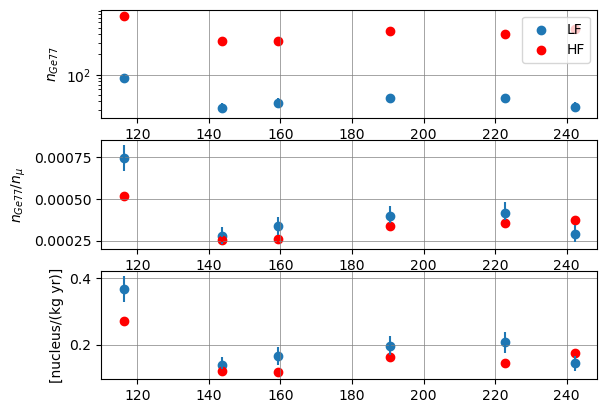

In [11]:
fig, (ax1,ax2,ax3)= plt.subplots(3,1)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
Ge77_lf=[x for i,x in enumerate(Ge77) if sim_mode[i]=='LF']
Ge77_hf=[x for i,x in enumerate(Ge77) if sim_mode[i]=='HF']
radius_lf=[x for i,x in enumerate(radius) if sim_mode[i]=='LF']
radius_hf=[x for i,x in enumerate(radius) if sim_mode[i]=='HF']
ax1.errorbar(radius_lf,Ge77_lf,np.sqrt(Ge77_lf),ls='none')
ax1.scatter(radius_lf,Ge77_lf,label='LF')
ax1.errorbar(radius_hf,Ge77_hf,np.sqrt(Ge77_hf),ls='none',color='red')
ax1.scatter(radius_hf,Ge77_hf,color='red',label='HF')
ax1.set_ylabel('$n_{Ge77}$')
ax1.set_yscale('log')
ax1.legend(loc='upper right')

Ge77_lf=[x for i,x in enumerate(Ge77Eff) if sim_mode[i]=='LF']
Ge77_hf=[x for i,x in enumerate(Ge77Eff) if sim_mode[i]=='HF']
Ge77_err_lf=[x for i,x in enumerate(Ge77Eff_err) if sim_mode[i]=='LF']
Ge77_err_hf=[x for i,x in enumerate(Ge77Eff_err) if sim_mode[i]=='HF']
ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.errorbar(radius_lf,Ge77_lf,Ge77_err_lf,ls='none')
ax2.scatter(radius_lf,Ge77_lf,label='LF')
ax2.errorbar(radius_hf,Ge77_hf,Ge77_err_hf,ls='none',color='red')
ax2.scatter(radius_hf,Ge77_hf,color='red',label='HF')
ax2.set_ylabel('$n_{Ge77}/n_\mu$')


ax3.grid(color='gray', linestyle='-', linewidth=0.5)
Ge77_lf=[x for i,x in enumerate(Ge77Rate) if sim_mode[i]=='LF']
Ge77_hf=[x for i,x in enumerate(Ge77Rate) if sim_mode[i]=='HF']
Ge77_err_lf=[x for i,x in enumerate(Ge77Rate_err) if sim_mode[i]=='LF']
Ge77_err_hf=[x for i,x in enumerate(Ge77Rate_err) if sim_mode[i]=='HF']
ax3.errorbar(radius_lf,Ge77_lf,Ge77_err_lf,ls='none')
ax3.scatter(radius_lf,Ge77_lf,label='LF')
ax3.errorbar(radius_hf,Ge77_hf,Ge77_err_hf,ls='none',color='red')
ax3.scatter(radius_hf,Ge77_hf,color='red',label='HF')
ax3.set_ylabel('[nucleus/(kg yr)]')
fig.savefig(f'out/{version}/neutron-Ge77-capture-new-samples_{version}.png')

In [12]:
#np.set_printoptions(threshold=sys.maxsize)
df = pd.DataFrame({'Sample': sample, 'Mode': sim_mode, 'Design': design, 'Radius[cm]': radius, 'Thickness[cm]': thickness, 'NPanels': npanels, 'Phi[deg]': phi, 'Theta[deg]': theta, 'Length[cm]':Length, 'Height[cm]': height, 'ZPosition[cm]':zpos, 'Volume[cm3]':volume, 'Ge-77[nevents]':Ge77, 'Ge-77_err[nevents]':np.sqrt(np.array(Ge77)), 'Ge77-Eff': Ge77Eff, 'Ge77-Eff_err': Ge77Eff_err, 'Ge77-Rate[nucleus/(kg yr)]': Ge77Rate, 'Ge77-Rate_err[nucleus/(kg yr)]': Ge77Rate_err, 'Ge77-Rate_err_stat[nucleus/(kg yr)]': Ge77Rate_err_stat, 'nprimaries':nprimaries, 'total_neutrons': n_neutrons})
df = df.drop_duplicates(subset=df.columns.difference(['Ge77-Rate_err_stat[nucleus/(kg yr)]']),keep='first')
df=df.sort_values(by=['Sample','Radius[cm]','Mode'],ignore_index=True)
df

,Sample,Mode,Design,Radius[cm],Thickness[cm],NPanels,Phi[deg],Theta[deg],Length[cm],Height[cm],...,Volume[cm3],Ge-77[nevents],Ge-77_err[nevents],Ge77-Eff,Ge77-Eff_err,Ge77-Rate[nucleus/(kg yr)],Ge77-Rate_err[nucleus/(kg yr)],Ge77-Rate_err_stat[nucleus/(kg yr)],nprimaries,total_neutrons
0,0,HF,4.0,222.6,6.9,186.0,110.895057,43.4,59.6,300.0,...,25230656.89,404,20.099751,0.000353,0.000018,0.145555,0.007814,0.007103,9850000,1144840
1,0,LF,4.0,222.6,6.9,186.0,110.895057,43.4,59.6,300.0,...,25230656.89,45,6.708204,0.000417,0.000062,0.206408,0.031056,0.030599,50000,114520
2,1,HF,4.0,143.7,12.6,109.0,189.233767,8.6,73.2,300.0,...,32093916.99,321,17.916473,0.000256,0.000014,0.119284,0.007079,0.006601,9550000,1254516
3,1,LF,4.0,143.7,12.6,109.0,189.233767,8.6,73.2,300.0,...,32093916.99,32,5.656854,0.000280,0.000049,0.138418,0.024631,0.023864,50000,121438
4,2,HF,4.0,242.2,10.7,66.0,312.522434,6.4,22.3,300.0,...,9024407.20,476,21.817424,0.000371,0.000017,0.174147,0.008721,0.008001,9700000,1282430
5,2,LF,4.0,242.2,10.7,66.0,312.522434,6.4,22.3,300.0,...,9024407.20,33,5.744563,0.000291,0.000051,0.144938,0.025403,0.025350,50000,119599
6,3,HF,4.0,159.2,5.8,330.0,62.504487,29.8,57.6,300.0,...,34066066.38,320,17.888544,0.000257,0.000014,0.117680,0.006994,0.006601,9650000,1245871
7,3,LF,4.0,159.2,5.8,330.0,62.504487,29.8,57.6,300.0,...,34066066.38,38,6.164414,0.000336,0.000054,0.165847,0.027116,0.026319,50000,120357
8,4,HF,4.0,116.2,1.1,52.0,396.663089,39.6,35.7,300.0,...,707709.39,758,27.531800,0.000515,0.000019,0.270351,0.011233,0.009719,9950000,1470452
9,4,LF,4.0,116.2,1.1,52.0,396.663089,39.6,35.7,300.0,...,707709.39,89,9.433981,0.000742,0.000079,0.367241,0.039641,0.039412,50000,127302


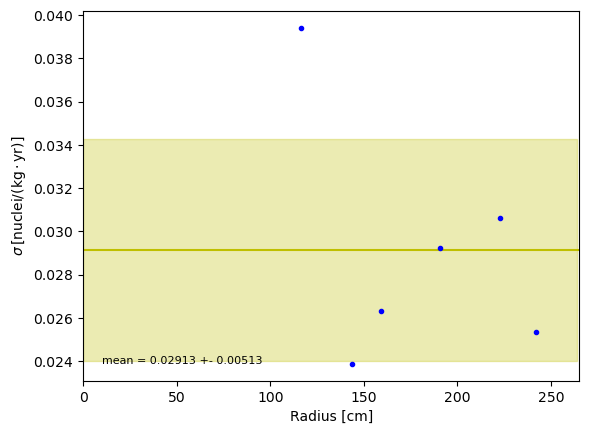

In [13]:

stat_err=[x for i,x in enumerate(Ge77Rate_err_stat) if sim_mode[i]=='LF']

values, bins = np.histogram(stat_err, bins=10)    
x = (bins[:-1] + bins[1:]) / 2
#plt.scatter(x,values)
plt.axhline(y = np.mean(stat_err), color = 'y')
plt.plot(radius[0:nLF],stat_err,'b',marker=".",linewidth=0)

# only one line may be specified; full height

ymin=np.mean(stat_err)-np.std(stat_err)
ymax=np.mean(stat_err)+np.std(stat_err)
x=[i for i in range(0,265)]
y1=[ymin for i in range(0,265)]
y2=[ymax for i in range(0,265)]
plt.fill_between(x,y1,y2,color='y', alpha=0.3)
plt.xlim(0.,265.)
plt.xlabel('Radius [cm]')
plt.ylabel(r'$\sigma\,\rm [nuclei/(kg \cdot yr)]$')
err_min=(np.min(stat_err))*1.
plt.text(10,err_min,f"mean = {np.round(np.mean(stat_err),5)} +- {np.round(np.std(stat_err),5)}",fontsize=8)
plt.savefig(f"out/{version}/noise_LF_new_samples_{version}.png")

In [14]:
f=open(f'out/{version}/Ge77_rates_new_samples_{version}.csv',"w")
f.write(f"# LF noise: mean = {np.mean(Ge77Rate_err_stat[0:nLF])} +- {np.std(Ge77Rate_err_stat[0:nLF])}"+"\n")
f.close()
df.to_csv(f'out/{version}/Ge77_rates_new_samples_{version}.csv',mode='a')